**Banco de Dados - Ranking das Vendas de Videogames.**


Dataset Inicial.

In [4]:
# Carrega o dataset
df = pd.read_csv('vgsales.csv')

# Imprime as primeiras linhas do dataset
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


Funções de tratativa Outliers, cálculo de médias e escalonamento.

In [3]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Função para remover outliers
def no_outliers(df):
    # Inicializa o modelo Isolation Forest para detecção de outliers
    clf = IsolationForest(random_state=42, contamination='auto')  # 'auto' define a contaminação com base na proporção de outliers

    # Ajusta o modelo e prevê outliers
    outlier_preds = clf.fit_predict(df[['Year', 'Global_Sales']])

    # Filtra os outliers (mantém apenas dados normais)
    df_no_outliers = df[outlier_preds == 1]  # 1 indica dados normais, -1 indica outliers

    return df_no_outliers

# Função para calcular a média das vendas globais por plataforma, gênero e publicadora
def calculate_avg(df):
    avg_platform = df.groupby(['Platform'])['Global_Sales'].mean().reset_index()
    avg_platform.columns = ['Platform', 'Platform_Avg']

    avg_genre = df.groupby(['Genre'])['Global_Sales'].mean().reset_index()
    avg_genre.columns = ['Genre', 'Genre_Avg']

    avg_publisher = df.groupby(['Publisher'])['Global_Sales'].mean().reset_index()
    avg_publisher.columns = ['Publisher', 'Publisher_Avg']

    return avg_platform, avg_genre, avg_publisher

# Função para mesclar as médias calculadas ao DataFrame original
def merge_avg(df, avg_platform, avg_genre, avg_publisher):
    df = df.merge(avg_platform, on='Platform', how='left')
    df = df.merge(avg_genre, on='Genre', how='left')
    df = df.merge(avg_publisher, on='Publisher', how='left')

    return df

# Função para escalonar as colunas de entrada
def scale_x(x):
    x[['Year']] = MinMaxScaler().fit_transform(x[['Year']])
    x[['Platform_Avg', 'Genre_Avg', 'Publisher_Avg']] = QuantileTransformer().fit_transform(x[['Platform_Avg', 'Genre_Avg', 'Publisher_Avg']])

    return x

# Função para escalonar a coluna de saída (vendas globais)
def scale_y(y):
    scaler = QuantileTransformer()
    y[['Global_Sales']] = scaler.fit_transform(y[['Global_Sales']])

    return y

# Função para remover colunas não necessárias de X
def drop_columns_x(x):
    x = x.drop(['Platform', 'Genre', 'Publisher', 'Global_Sales'], axis=1)
    return x

# Função para manter apenas a coluna de vendas globais em y
def drop_columns_y(y):
    return y['Global_Sales']

Dataset sem Outliers e valores nulos.

In [5]:
# Seleciona apenas as colunas necessárias
df = df[['Platform', 'Year', 'Genre', 'Publisher', 'Global_Sales']]

# Remove linhas com valores nulos
df = df.dropna()

# Embaralha as linhas
df = df.sample(frac=1, random_state=42).reset_index()

# Remove outliers
df = no_outliers(df)

df

,index,Platform,Year,Genre,Publisher,Global_Sales
0,3527,DS,2008.0,Simulation,Ubisoft,0.57
1,12216,WiiU,2014.0,Action,Namco Bandai Games,0.07
2,7940,PSV,2015.0,Action,Namco Bandai Games,0.19
3,3030,PC,2011.0,Role-Playing,Unknown,0.67
4,7144,GBA,2001.0,Misc,Takara,0.22
...,...,...,...,...,...,...
16285,5274,Wii,2007.0,Strategy,Nintendo,0.35
16286,13655,PSP,2011.0,Role-Playing,Nippon Ichi Software,0.04
16287,5474,XB,2003.0,Shooter,Eidos Interactive,0.33
16289,16087,Wii,2008.0,Sports,Takara Tomy,0.01


Divide os dados em conjuntos de treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df, test_size=0.2, random_state=42)

Cálculo de média de platform, genre e publisher.

In [ ]:
avg_platform, avg_genre, avg_publisher = calculate_avg(X_train)

avg_platform

,Platform,Platform_Avg
0,3DS,0.181420
1,DC,0.202286
2,DS,0.201015
3,GB,0.397241
4,GBA,0.248037
5,GC,0.237452
6,N64,0.277251
7,NG,0.050000
8,PC,0.132925
9,PS,0.284392


Mesclagem das tabelas de entrada.

In [ ]:
X_train = merge_avg(X_train, avg_platform, avg_genre, avg_publisher).fillna(0)
X_test = merge_avg(X_test, avg_platform, avg_genre, avg_publisher).fillna(0)

X_test

,index,Platform,Year,Genre,Publisher,Global_Sales,Platform_Avg,Genre_Avg,Publisher_Avg
0,5808,PS,1999.0,Misc,Activision,0.31,0.284392,0.243389,0.342615
1,10931,Wii,2009.0,Action,Mindscape,0.09,0.292341,0.264707,0.135000
2,5925,DS,2009.0,Misc,Majesco Entertainment,0.30,0.201015,0.243389,0.146000
3,13021,PC,2007.0,Simulation,Microsoft Game Studios,0.05,0.132925,0.250323,0.317156
4,7046,PS,1996.0,Action,American Softworks,0.23,0.284392,0.264707,0.000000
...,...,...,...,...,...,...,...,...,...
2738,10911,GC,2004.0,Shooter,O3 Entertainment,0.09,0.237452,0.296923,0.065000
2739,11647,PS2,2005.0,Action,Namco Bandai Games,0.08,0.300104,0.264707,0.183793
2740,9201,X360,2011.0,Misc,Konami Digital Entertainment,0.14,0.327655,0.243389,0.203183
2741,7669,XB,2001.0,Sports,Acclaim Entertainment,0.20,0.243461,0.292340,0.257984


Normalização das colunas via teste e treino.

In [ ]:
X_train = scale_x(X_train)
X_test = scale_x(X_test)
y_train = scale_y(y_train)
y_test = scale_y(y_test)

X_train

,index,Platform,Year,Genre,Publisher,Global_Sales,Platform_Avg,Genre_Avg,Publisher_Avg
0,9651,PSP,0.631579,Role-Playing,Zushi Games,0.13,0.176176,0.318819,0.139640
1,8351,PSP,0.894737,Sports,Konami Digital Entertainment,0.17,0.176176,0.808308,0.395395
2,5795,PS2,0.263158,Sports,Sony Computer Entertainment,0.31,0.777277,0.808308,0.850851
3,11304,X360,0.894737,Platform,Namco Bandai Games,0.08,0.884384,1.000000,0.323323
4,14576,DS,0.842105,Puzzle,Unknown,0.03,0.293293,0.104605,0.132132
...,...,...,...,...,...,...,...,...,...
10967,2175,PS2,0.473684,Action,Ubisoft,0.95,0.777277,0.514014,0.587588
10968,6729,XB,0.473684,Shooter,Ubisoft,0.25,0.454955,0.913914,0.587588
10969,11594,PS2,0.421053,Misc,Sony Computer Entertainment,0.08,0.777277,0.220721,0.850851
10970,13284,GC,0.368421,Role-Playing,THQ,0.05,0.407908,0.318819,0.786286


Remoção das colunas desnecessárias.

In [ ]:
X_train = drop_columns_x(X_train)
X_test = drop_columns_x(X_test)
y_train = drop_columns_y(y_train)
y_test = drop_columns_y(y_test)

X_train

,index,Year,Platform_Avg,Genre_Avg,Publisher_Avg
0,9651,0.631579,0.176176,0.318819,0.139640
1,8351,0.894737,0.176176,0.808308,0.395395
2,5795,0.263158,0.777277,0.808308,0.850851
3,11304,0.894737,0.884384,1.000000,0.323323
4,14576,0.842105,0.293293,0.104605,0.132132
...,...,...,...,...,...
10967,2175,0.473684,0.777277,0.514014,0.587588
10968,6729,0.473684,0.454955,0.913914,0.587588
10969,11594,0.421053,0.777277,0.220721,0.850851
10970,13284,0.368421,0.407908,0.318819,0.786286


Aplicação da Regressão Linear.

In [ ]:
# Treina o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Faz previsões no conjunto de teste
y_pred = model.predict(X_test)

Avaliação do modelo.

In [ ]:
# Calcula o R² Score
r2 = r2_score(y_test, y_pred)
# Calcula o erro quadrático médio (MSE)
mse_lr = mean_squared_error(y_test, y_pred)

# Exibe o resultado
print("R² score:", r2)
print(f"Mean Squared Error: {mse_lr}")

R² score: 0.9976851197735283
Mean Squared Error: 0.00019443820803249662


Gráfico das vendas Teste x Previsão.

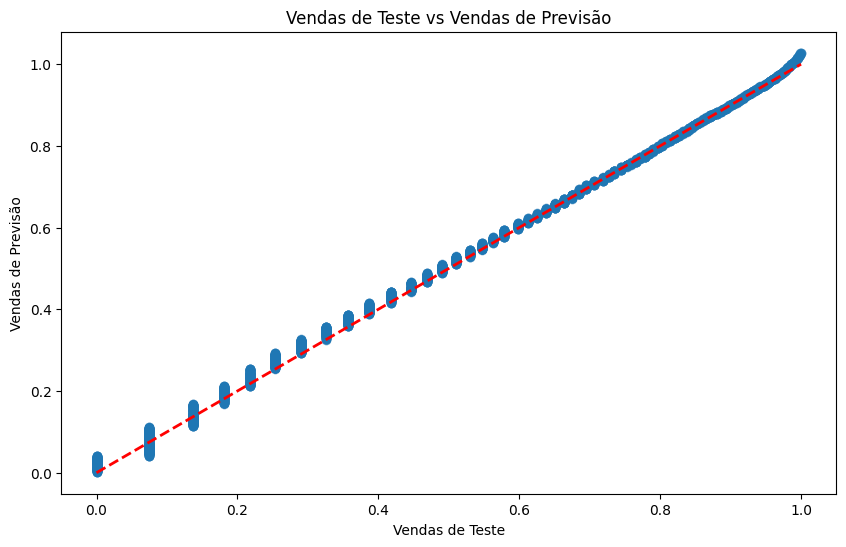

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Vendas de Teste vs Vendas de Previsão')
plt.xlabel('Vendas de Teste')
plt.ylabel('Vendas de Previsão')
plt.show()

Gráfico heatmap vendas Publisher x Genre

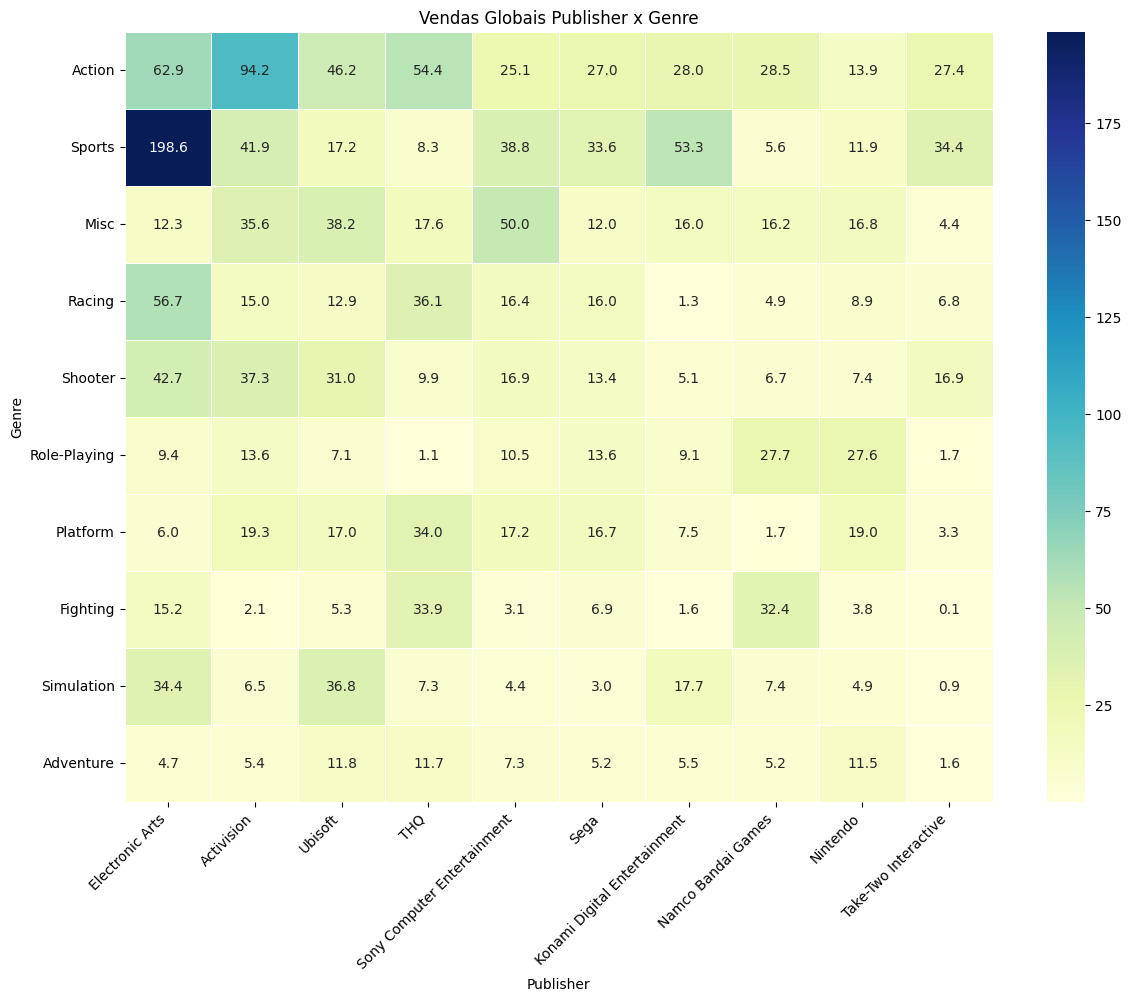

In [20]:
# Identifica top 10 Publishers
top_publishers = df.groupby('Publisher').agg({'Global_Sales': 'sum'}).nlargest(10, 'Global_Sales').index

# Identifica top 10 Gêneros
top_genres = df.groupby('Genre').agg({'Global_Sales': 'sum'}).nlargest(10, 'Global_Sales').index

# Filtra dataframe
filtered_df = df[df['Publisher'].isin(top_publishers) & df['Genre'].isin(top_genres)]

# Agrupar dataframe por Genre e Publisher
grouped_df = filtered_df.groupby(['Genre', 'Publisher']).agg({'Global_Sales': 'sum'}).reset_index()

# Criar um pivô de Genre e Publisher
pivot_df = grouped_df.pivot(index='Genre', columns='Publisher', values='Global_Sales')

# Ordenar pivô
pivot_df = pivot_df[top_publishers].loc[top_genres]

# Traçar um heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)

plt.title('Vendas Globais Publisher x Genre')
plt.xlabel('Publisher')
plt.ylabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

Gráfico Média de vendas por plataforma.


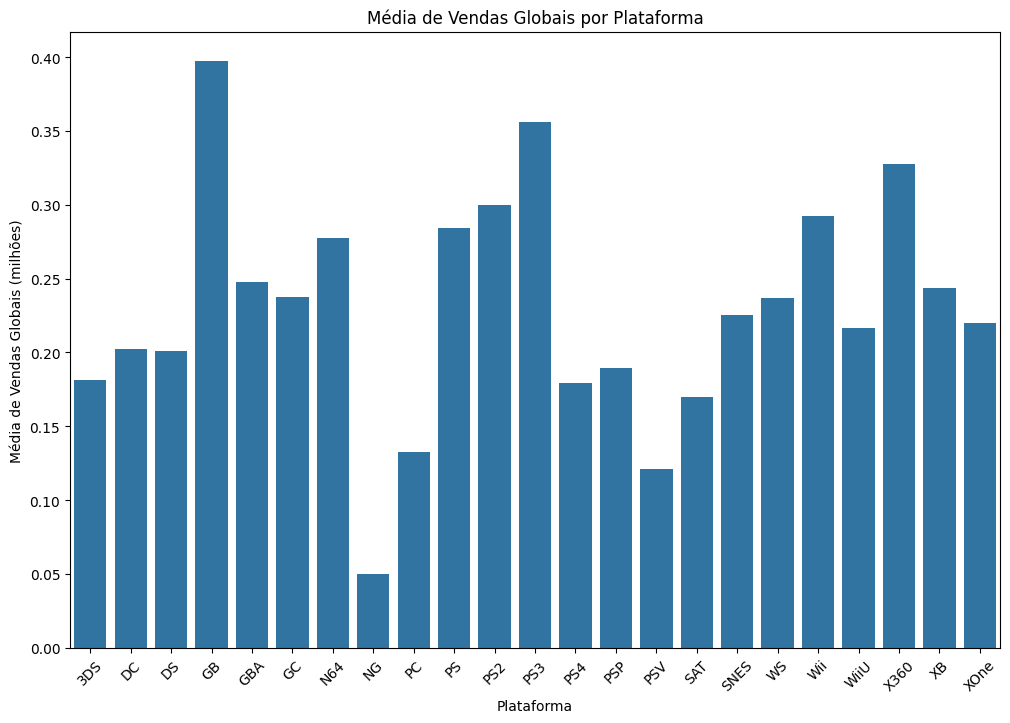

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Platform', y='Platform_Avg', data=avg_platform)
plt.title('Média de Vendas Globais por Plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Média de Vendas Globais (milhões)')
plt.xticks(rotation=45)
plt.show()

Histograma das vendas globais (Global_Sales).

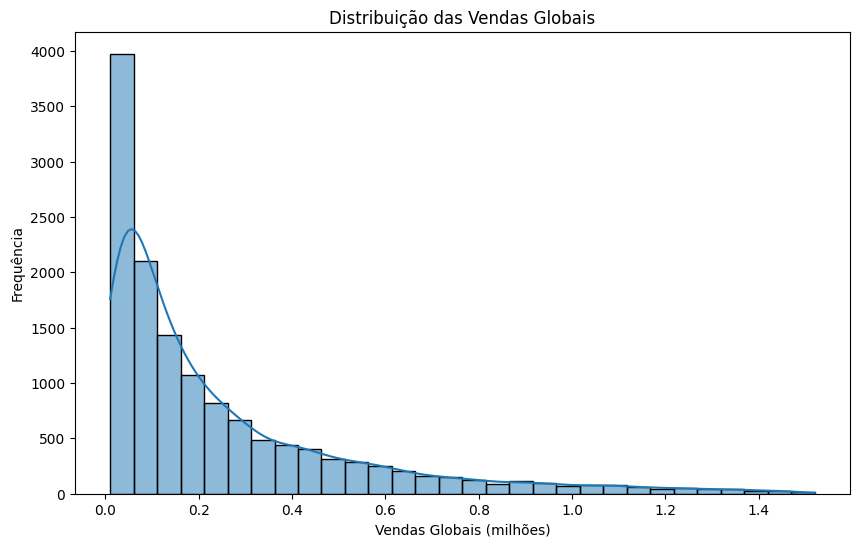

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Global_Sales'], bins=30, kde=True)
plt.title('Distribuição das Vendas Globais')
plt.xlabel('Vendas Globais (milhões)')
plt.ylabel('Frequência')
plt.show()